# Test bench 2-dofs case study

This test bench consists of a steel frame equipped with two electro-mechanical actuator + force transducer. The horizontal actuator applies a force fh [N] to the beam tip and measures the corresponding displacement uh [mm]. The vertical actuator applies a displacement uv [mm] to the beam tip and measures the corresponding reaction force fv [N].

<img src="assets\test_bench_2dof.jpg" alt="Test Bench 1-DoF" height="500">

Below is a schematic of the setup with main dimensions in [mm] and indication of forces/displacements, which has to be used to produce a finite-element model. For each part of the test bench (frame, supports and specimen) cross-sections are given with main dimensions. All parts are made of steel (elastic modulus $E=210e3$ MPa), expect for the specimen, which is made in aluminum (elastic modulus $E=70e3$ MPa)

<img src="assets\test_bench_2dof_CAD.png" alt="Test Bench 1-DoF" height="500">

As you can see, the figure already reports a tentative numbering of nodes (1-12), which you can use to define the finite-element model. The coordinates of each node, shall be expressed w.r.t. coordinate system x-y-z and computed based on the dimensions of the drawing.

The following loadigs are applied to the specimen:

$u_v(t) = 20 \sin(4\pi t)$ [mm]

$f_h(t) = 100 \sin(2\pi t)$ [N]

The corresponding $f_v(t)$ and $u_h(t)$ are measured.

The bending stiffness $K_b$ of the specimen defines the proportionality between $u_v$ and $f_v$:

$f_v = K_b u_v$

The axial stiffness $K_a$ of the specimen defines the proportionality between $u_h$ and $f_h$:

$f_h = K_a u_h$

# Assignment
In this project both DIGITAL and PHYSICAL TWINS are represented by the same finite-element model:
* The PHYSICAL TWIN is simulated considering that actual material for the specimen, which is aluminum (elastic modulus $E=70e3$ MPa).
* The DIGITAL TWIN assumes an initial guess for the material parameters of the specimen, which is close to aluminum (elastic modulus $E=100e3$ MPa) but not exact.
* A "model calibration" service shall be developed to estimate the correct value for the elastic modulus of the specimen, by comparing the force displacement relationships $f_h = K_a u_h$ and $f_v = K_b u_v$ between DIGITAL TWIN and PHYSICAL TWIN.
* In this project, 1D elements (beam) are sufficient to construct the finite-element model of each of the selected test bench.

# How to build a finite-element model in YaFEM

YaFEM (Yet another finite-element modeling toolbox) is a toolbox to create simple finite-element models made of 1D, 2D and 3D elements.

In the following, it is demonstrated how to build the finite-element model for a simple cantilever beam subjected to a vertical tip displacement and horizontal tip force.

<img src="assets\cantilever_beam.jpg" alt="Cantilever beam example" height="200">

Step 1: define model parameters

In [1]:
_l = 600.0 # length of the beam [mm]
_E = 210e3 # Young's modulus [N/mm^2]

# cross-section parameters (see the sketch above)
_b = 40.0 # cross section width [mm]
_h = 60.0 # cross section height [mm]
_s = 5.0 # cross section thickness [mm]
_A = _b*_h - (_b-2*_s) * (_h-2*_s) # cross-section area [mm2]
_Ixx = _b*_h**3/12 - (_b-2*_s)*(_h-2*_s)**3/12 # moment of inertia about x-axis [mm4]
_Iyy = _h*_b**3/12 - (_h-2*_s)*(_b-2*_s)**3/12 # moment of inertia about y-axis [mm4]

# parameters of the applied boundary conditions (displacements and forces)
_uv = 5.0 # vertical displacement applied to node 2 [mm]
_fh = 100.0 # horizontal force applied to node 2 [N]

Step 2: import YaFEM modules

In [3]:
from yafem.nodes import *
from yafem.elem import *
from yafem.model import *
from yafem.simulation import *  

Step 3: create the FE model nodes

In [4]:
# nodal parameters
my_nodes_pars = {}
my_nodes_pars['nodal_data'] = np.array([[1,0.0,0.0,0.0],
                                        [2,_l,0.0,0.0]])

# create the nodes
my_nodes = nodes(my_nodes_pars)

Step 4: create the FE model elements

In [5]:
# parameters of the element
my_beam3d_pars = {}
my_beam3d_pars['shape'] = 'generic'
my_beam3d_pars['A'] = _A
my_beam3d_pars['Ixx'] = _Ixx
my_beam3d_pars['Iyy'] = _Iyy
my_beam3d_pars['E'] = _E
my_beam3d_pars['Jv'] = my_beam3d_pars['Ixx'] + my_beam3d_pars['Iyy']
my_beam3d_pars['nodal_labels'] = [1,2]

# initialization of the element list
my_elements = []

# add one beam3d element to the list
my_elements.append(beam3d(my_nodes,my_beam3d_pars))

Step 5: create the FE model

In [6]:
# model parameters
my_model_pars = {}

# constrained degrees of freedom (all dofs of node 1)
my_model_pars['dofs_c'] = np.array([[1,1],[1,2],[1,3],[1,4],[1,5],[1,6]])

# degrees of freedom subjected to force history (horizontal dofs of node 2)
my_model_pars['dofs_f'] = np.array([[2,1]])

# degrees of freedom subjected to displacement history (vertical dofs of node 2)
my_model_pars['dofs_u'] = np.array([[2,3]])

# force history (21 steps)
my_model_pars['g_f'] = np.linspace(0,_fh,21)

# displacement history (21 steps)
my_model_pars['g_u'] = np.linspace(0,_uv,21)

# create the model
my_model = model(my_nodes,my_elements,my_model_pars)

# list of model dofs (left column is node number, right column is the dof number)
my_model.dofs

array([[2, 1],
       [2, 2],
       [2, 3],
       [2, 4],
       [2, 5],
       [2, 6]])

Step 6: create and execute the simulation

In [7]:
# simulation parameters
simulation_pars = {}

# create the simulation
my_simulation = simulation(my_model,simulation_pars)

# perform static analysis (u: displacements, l: applied forces, r: restoring force)
[u,l,r] = my_simulation.static_analysis()

step 1 converged in 1 iterations with residual 0.0
step 2 converged in 1 iterations with residual 0.0
step 3 converged in 1 iterations with residual 2.533397151339718e-16
step 4 converged in 1 iterations with residual 1.948855009542913e-13
step 5 converged in 1 iterations with residual 1.5606478487777726e-13
step 6 converged in 1 iterations with residual 2.6028271925092146e-13
step 7 converged in 1 iterations with residual 2.2320744978286588e-13
step 8 converged in 1 iterations with residual 1.9079615774162621e-16
step 9 converged in 1 iterations with residual 1.6966474305040974e-16
step 10 converged in 1 iterations with residual 1.563796169202795e-13
step 11 converged in 1 iterations with residual 1.4219116427499392e-13
step 12 converged in 1 iterations with residual 3.8191797009497927e-16
step 13 converged in 1 iterations with residual 2.406963186199065e-13
step 14 converged in 1 iterations with residual 2.2352717717389e-13
step 15 converged in 1 iterations with residual 2.0864549570

Step 7: post-process the results

5942.708333333334

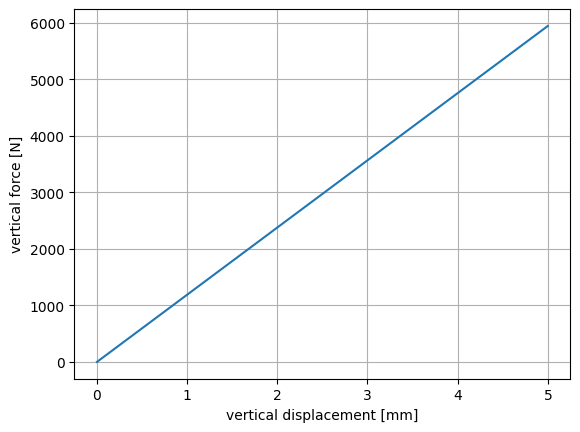

In [8]:
plt.plot(u[my_model.find_dofs([[2,3]]).squeeze(),:],l[0,:])
plt.xlabel('vertical displacement [mm]')
plt.ylabel('vertical force [N]')
plt.grid()

# this is done to check the correctness of the results
_kb = 3*_E*_Ixx/_l**3 # theoretical bendind stiffness
_fv_max = _kb*_uv # theoretical maximum vertical force
_fv_max

0.00031746031746031746

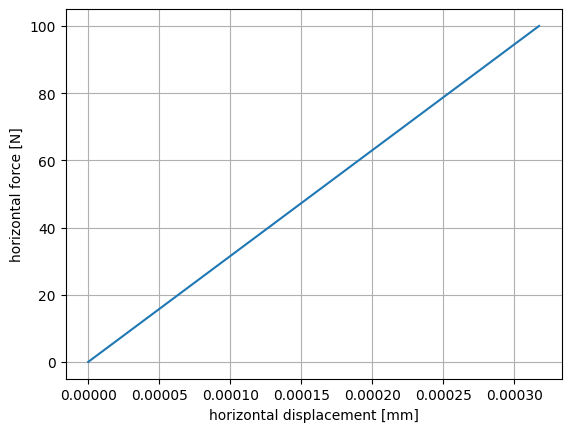

In [9]:
plt.plot(u[my_model.find_dofs([[2,1]]).squeeze(),:],my_model.g_f[0,:])
plt.xlabel('horizontal displacement [mm]')
plt.ylabel('horizontal force [N]')
plt.grid()

# checks the correctness of the results
_ka = _E*_A/_l # theoretical axial stiffness
_uh_max = _fh/_ka # theoretical maximum horizontal displacement
_uh_max